In [11]:
# Final draft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.interpolate import RegularGridInterpolator

In [395]:
# Constants in cgs
g = 6.67430e-8 # cm^3 g^-1 s^-2 (gravitational constant)
a_rad = 7.5657e-15 # erg cm^-3 K^-4 (radiation constant)
c = 2.99792458e10 # cm s^-1 (speed of light)
R_gas = 8.314e7 # erg mol^-1 K^-1 (ideal gas constant)
sigma = 5.670374419e-5 # erg cm^-2 s^-1 K^-4 (Stefan–Boltzmann constant)
N_A = 6.0221415e23 # Avogadro's number
k = 1.3807e-16 # cm^2*g/s^2/K*-1 (Boltzmann constant)

In [233]:
# Solar reference values for a 1.5 M⊙ ZAMS
default_M = 1.5 * 1.9891e33   # g (1.5 M_sun)
default_R = 1.4 * 7.0e10      # cm (~1.4 R_sun)
default_L = 5 * 3.8e33     # erg s^-1 (~5 L_sun)

# Solar metallicity
X = 0.70
Y = 0.28
Z = 0.02

# mean molecular weight
def mu(X=X):  

    return 4 / (3+5*X) # assume fully ionized gas

# density
def rho(P, T, X=X):
    P_rad = a_rad * T**4 / 3.
    P_gas = P - P_rad
    if P_gas <= 0:
        P_gas = 1e-12 * P  # tiny non-zero value, avoid negative P_gas

    return P_gas * mu(X) / (R_gas * T)

# load opacity table
# selected from original OP file - uploaded to github
def read_op_table(filename):
    df = pd.read_csv(filename, sep=',', header=0)
    logT = df.iloc[:,0].astype(float).values
    logR = np.array(df.columns[1:], dtype=float)
    kappa = df.iloc[:,1:].astype(float).values

    return logT, logR, kappa

# build and cashe interpolator
# grid interpolation routine from scipy.interpolate
op_table_path = os.path.expanduser("~/path/to/OP_Table_solar.csv")
logT, logR, kappa = read_op_table(op_table_path)
interpolator = RegularGridInterpolator(
    (logT, logR),      
    kappa,
    bounds_error=False,
    fill_value=None
)

# Opacity interpolation with boundary clamping
def op_interpol(T, rho_val):
    T6 = T / 1e6
    R_val = rho_val / (T6**3)
    # clamp to grid
    lt_min, lt_max = logT[0], logT[-1]
    lr_min, lr_max = logR[0], logR[-1]
    lt = np.clip(np.log10(T), lt_min, lt_max)
    lr = np.clip(np.log10(R_val), lr_min, lr_max)
    logkappa = interpolator((lt, lr))

    return float(10**logkappa)

# Nuclear energy generation rates
def T9(T): 

    return T / 1e9

# pp chain
def g11(T):
    t9 = T9(T)

    return 1 + 3.82*t9 + 1.51*t9**2 + 0.144*t9**3 - 0.0114*t9**4

def eps_pp(rho_val, T, X=X, psi=1.0, f11=1.0):
    # approximations: i) weak screening - f11 ~ 1; ii) constant psi ~ 1 (for T ~ 1e7 K)
    t9 = T9(T)

    return 2.57e4 * psi * f11 * g11(T) * rho_val * X**2 * t9**(-2/3) \
           * np.exp(-3.381/t9**(1/3)) # Stellar Structure & Evolution (SSE) eq 18.63

# CNO cycle
def g14_1(T):
    t9 = T9(T)

    return 1 - 2*t9 + 3.41*t9**2 - 2.437*t9**3

def eps_cno(rho_val, T, X=X, X_CNO=None):
    if X_CNO is None:
        X_CNO = 0.5*Z # roughly half of total metal
    t9 = T9(T)

    return 8.24e25 * g14_1(T) * X_CNO * X * rho_val * t9**(-2/3) \
           * np.exp(-15.231*t9**(-1/3) - (t9/0.8)**2) # SSE eq. 18.65

def eps_tot(rho_val, T, X=X):
    return eps_pp(rho_val, T, X) + eps_cno(rho_val, T, X)

# Temperature gradients
def del_rad(P, T, L_r, M_r):
    rho_val = rho(P, T)
    kappa = op_interpol(T, rho_val)

    return (3/(16*np.pi*a_rad*c*g)) * (P*kappa/T**4) * (L_r/M_r) # radiative; Steller Interiors (SI) eq 4.30

def del_ad(P, T):
    P_rad = a_rad * T**4 / 3
    beta = (P - P_rad)/P

    return (1 + (1-beta)**2/(beta*(4-3*beta))) \
           / (2.5 + 4*(1-beta)**2/(beta*(4-3*beta))) # adiabatic; Cox & Giuli eq 10.110

# Inner boundary (load1): outward start just above m=0
def load1(Pc, Tc, M, X=X, Z=Z, core_type='radiative'):
    rho_c = rho(Pc, Tc)
    eps_c = eps_tot(rho_c, Tc)
    kappa_c = op_interpol(Tc, rho_c)

    m0 = 1e-11 * M # very small non-zero value
    l0 = float(eps_c * m0) # SSE eq 11.4
    p0 = float(Pc - (3*G*rho_c**(4/3))/(8*np.pi**(1/3)) * m0**(2/3)) # SSE eq 11.6
    r0 = float((3*m0/(4*np.pi*rho_c))**(1/3)) # SSE eq 11.3
    
    # T differs with radiative/convective core: SSE eq 11.9
    if core_type == 'radiative':
        delta = (1/(2*a_rad*c))*(3/(4*np.pi))**(2/3) \
              * kappa_c * eps_c * rho_c**(4/3) * m0**(2/3)
        T4    = Tc**4 - delta
        T0    = float(T4**0.25) if T4 > 0 else float(Tc)
    elif core_type == 'convective':
        T0 = float(np.exp(
            np.log(Tc)
            - (np.pi/6)**(1/3) * G * del_ad(Pc,Tc)
              * rho_c**(4/3) / Pc
            * m0**(2/3)
        ))

    return [l0, p0, r0, T0]

# Outer boundary (load2): inward start from surface
def load2(Ls, M, R):
    ls = float(Ls)
    rs = float(R)
    Teff = float((Ls/(4*np.pi*R**2*sigma))**0.25) # Eddington grey atmosphere: T → T_eff

    T0 = (0.5 * Ls/(4*np.pi*R**2*sigma))**0.25

    # integrate P(tau) from 0 ~ 2/3: SSE eq 11.16
    def dP_dtau(tau, P_arr):
        Pv = float(P_arr)
        Tt = (3.0/4.0 * Ls/(4.0*np.pi*R**2*sigma) * (tau+2/3))**0.25
        rho_t = rho(Pv, Tt)
        k_t   = op_interpol(Tt, rho_t)

        return float((G*M/R**2)/k_t)
    
    # Photospheric start at τ=0: tiny gas pressure above P_rad
    P0 = float(a_rad*T0**4/3 * 1.00001)

    sol = solve_ivp(
        dP_dtau,
        [0.0, 2.0/3.0],
        [P0],
        atol=1e-6,
        rtol=1e-5
    )
    ps = float(sol.y[0, -1])
    
    return [ls, ps, rs, Teff]

# Stellar structure ODEs
def derivs(m, y):
    l, p, r, T = y
    rho_v = rho(p, T)
    eps_v = eps_tot(rho_v, T)

    # hydrostatic equilibrium
    dPdm = -G * m / (4.0*np.pi*r**4)
    # mass conservation
    drdm = 1.0 / (4.0*np.pi*r**2 * rho_v)
    # energy generation
    dldm = eps_v
    # energy transport: radiative/convective
    dTdm = dPdm * T/p * min(del_rad(p, T, l, m), del_ad(p, T))

    return [dldm, dPdm, drdm, dTdm]

# Shooting + root finding
def shootf(params, M=default_M):
    Pc, Tc, Ls, Rs = (float(params[0]), float(params[1]), float(params[2]), float(params[3]))

    # Set meeting point at mid-star
    mf = 0.5 * M

    y0_out = np.array(load1(Pc, Tc, M), dtype=float)
    sol_out = solve_ivp(derivs, [1e-11*M, mf], y0_out)

    y0_in = np.array(load2(Ls, M, Rs), dtype=float)
    sol_in = solve_ivp(derivs, [M, mf], y0_in, t_eval=[mf])

    return sol_out, sol_in

def y_difference(params):
    # Calculate residual
    sol_out, sol_in = shootf(params)
    y_out = sol_out.y[:, -1]
    y_in  = sol_in.y[:, 0]

    return y_out - y_in

def find_zams_solution(initial_guess):
    # Find root for residual = 0
    sol = root(lambda p: y_difference(p), initial_guess, method='hybr')

    return sol.x

if __name__ == '__main__':
    # Initial guesses
    guess = [2e17, 1.8e7, default_L, default_R]
    Pc_sol, Tc_sol, Ls_sol, Rs_sol = find_zams_solution(guess)
    print(f"Solution:\n"
          f"Pc = {Pc_sol:.3e} dyn/cm^2\n"
          f"Tc = {Tc_sol:.3e} K\n"
          f"Ls = {Ls_sol:.3e} erg/s = {(Ls_sol/(3.8e33)):.3e} L_solar\n"
          f"Rs = {Rs_sol:.3e} cm = {(Rs_sol/(7.0e10)):.3e} R_solar")

/var/folders/pj/ns2lf00941bd0l11h7vvprf80000gn/T/ipykernel_43992/1879934785.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Pv = float(P_arr)


Solution:
  Pc = 2.148e+17 dyn/cm^2
  Tc = 1.821e+07 K
  Ls = 1.714e+34 erg/s = 4.510e+00 L_solar
  Rs = 1.036e+11 cm = 1.479e+00 R_solar


In [393]:
# Integrate outward from core to meeting point
m_inner = 1e-11*default_M
m_fit   = 0.5*default_M
y0_out  = load1(Pc_sol, Tc_sol, default_M)
sol_out = solve_ivp(derivs,
                    [m_inner, m_fit],
                    y0_out,
                    t_eval=np.linspace(m_inner, m_fit, 250),
                    max_step=default_M/500)

# Integrate inward from surface to meeting point
y0_in   = load2(Ls_sol, default_M, Rs_sol)
sol_in  = solve_ivp(derivs,
                    [default_M, m_fit],
                    y0_in,
                    t_eval=np.linspace(default_M, m_fit, 250),
                    max_step=default_M/500)

m1 = sol_out.t / 1.989e33
y_out = sol_out.y

m2  = sol_in.t[::-1] / 1.989e33
y_in  = sol_in.y[:, ::-1]

l_prof2 = y_in[0] / 3.826e33
P_prof2 = y_in[1] / 1e17
r_prof2 = y_in[2] / 7e10
T_prof2 = y_in[3] / 1e7

l_prof1 = y_out[0] / 3.826e33
P_prof1 = y_out[1] / 1e17
r_prof1 = y_out[2] / 7e10
T_prof1 = y_out[3] / 1e7

/var/folders/pj/ns2lf00941bd0l11h7vvprf80000gn/T/ipykernel_43992/1879934785.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Pv = float(P_arr)


/var/folders/pj/ns2lf00941bd0l11h7vvprf80000gn/T/ipykernel_43992/4210965837.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(


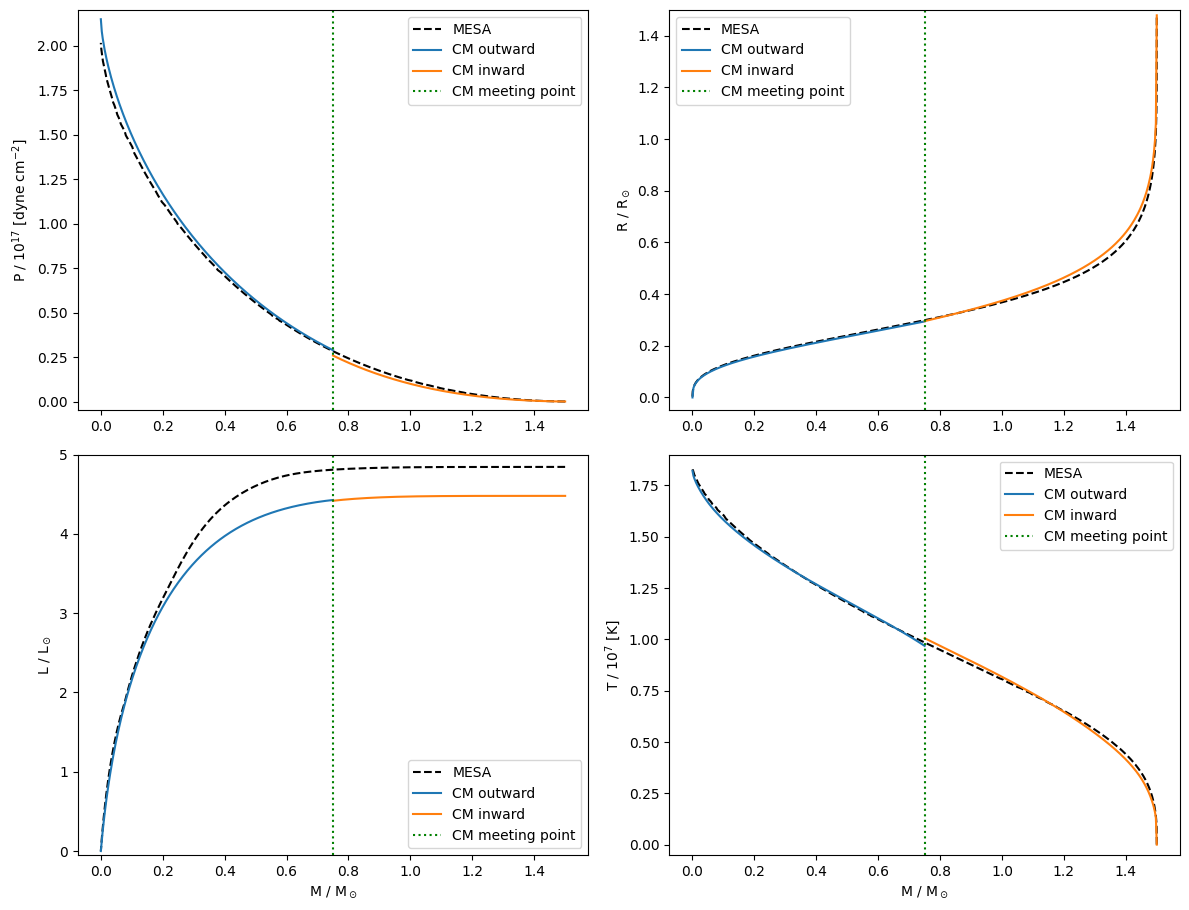

In [394]:
# read MESA profile - uploaded to github
df = pd.read_table(
    os.path.expanduser("~/path/to/profile5.data"),
    comment='#',
    delim_whitespace=True
)

cols = ['mass', 'logR', 'logT', 'logP', 'pp', 'cno', 'tri_alpha']

df = df.drop(df.columns[0], axis=1)
df = df.drop([0, 1, 2, 3], axis=0)
df = df.rename(columns={'2': 'mass', '3': 'logR', '4': 'logT', '6': 'logP', '10': 'pp', '11': 'cno', '12': 'tri_alpha'})
dff = pd.DataFrame(df[cols])
dff = dff.reset_index()
dff = dff.apply(pd.to_numeric, errors='coerce')
dff['eps_nuc'] = dff['pp'] + dff['cno'] + dff['tri_alpha']

dff_sorted = dff.sort_values('mass')
mass_g = dff_sorted['mass'] * 1.9891e33
dm_g   = mass_g.diff().fillna(mass_g.iloc[0])

# Integrate eps over small mass increments to find L ~ ∫ eps_nuc dm
dff_sorted['luminosity'] = (dff_sorted['eps_nuc'] * dm_g).cumsum()
dff['luminosity'] = dff_sorted['luminosity']

m_norm  = dff['mass'] # in solar mass
P_prof  = 10**dff['logP']  / 1e17 # dyne cm⁻²
r_prof  = 10**dff['logR']  #/ 7e10 # cm
T_prof  = 10**dff['logT']  / 1e7 # K
l_prof  = dff['luminosity'] / 3.826e33 # erg s⁻¹

# 9) Plot in a 2×2 grid
plt.figure(figsize=(12,10))

ax = plt.subplot(2,2,1)
ax.plot(m_norm, P_prof, color='black', linestyle='dashed')
ax.plot(m1, P_prof1)
ax.plot(m2, P_prof2)
ax.vlines(1.5/2, -0.05, 2.3, color='g', linestyles='dotted')
ax.set_ylim(-0.05, 2.2)
#ax.set_xlabel('M / M$_\\odot$'); 
ax.set_ylabel('P / 10$^{17}$ [dyne cm$^{-2}$]')
#ax.set_title('Pressure')
ax.legend(['MESA', 'CM outward', 'CM inward', 'CM meeting point'])

ax = plt.subplot(2,2,2)
ax.plot(m_norm, r_prof, color='black', linestyle='dashed')
ax.plot(m1, r_prof1)
ax.plot(m2, r_prof2)
ax.vlines(1.5/2, -0.05, 1.5, color='g', linestyles='dotted')
ax.set_ylim(-0.05, 1.5)
#ax.set_xlabel('M / M$_\\odot$'); 
ax.set_ylabel('R / R$_\\odot$')
#ax.set_title('Radius')
ax.legend(['MESA', 'CM outward', 'CM inward', 'CM meeting point'])

ax = plt.subplot(2,2,3)
ax.plot(m_norm, l_prof, color='black', linestyle='dashed')
ax.plot(m1, l_prof1)
ax.plot(m2, l_prof2)
ax.vlines(1.5/2, -0.05, 5, color='g', linestyles='dotted')
ax.set_ylim(-0.05, 5)
ax.set_xlabel('M / M$_\\odot$'); ax.set_ylabel('L / L$_\\odot$')
#ax.set_title('Luminosity')
ax.legend(['MESA', 'CM outward', 'CM inward', 'CM meeting point'])

ax = plt.subplot(2,2,4)
ax.plot(m_norm, T_prof, color='black', linestyle='dashed')
ax.plot(m1, T_prof1)
ax.plot(m2, T_prof2)
ax.vlines(1.5/2, -0.05, 1.9, color='g', linestyles='dotted')
ax.set_ylim(-0.05, 1.9)
ax.set_xlabel('M / M$_\\odot$'); ax.set_ylabel('T / 10$^{7}$ [K]')
#ax.set_title('Temperature')
ax.legend(['MESA', 'CM outward', 'CM inward', 'CM meeting point'])

#plt.suptitle('Radial Profiles - MESA', y=0.95)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()
